In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.axes import Axes
from torch._prims_common import DeviceLikeType
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm, trange

from bioemu.so3_sde import angle_from_rotmat, rotmat_to_rotvec, rotvec_to_rotmat
from se3diff.finetune import compute_finetune_loss, reverse_finetune_diffusion
from se3diff.models import DiGMixSO3SDE, ScoreNet
from se3diff.train import (
    compute_train_loss,
    igso3_mixture_marginal_pdf,
    reverse_diffusion,
)

In [2]:
sde = DiGMixSO3SDE()
score_model = ScoreNet(rot_embed_dim=32, time_embed_dim=32, hidden_dim=128)
# finetune_model = ScoreNet(rot_embed_dim=8, time_embed_dim=8, hidden_dim=32)
finetune_model = ScoreNet(rot_embed_dim=16, time_embed_dim=16, hidden_dim=64)
# finetune_model = ScoreNet(rot_embed_dim=32, time_embed_dim=32, hidden_dim=128)
device = "cuda" if torch.cuda.is_available() else "cpu"

Computing dlog_igso3_expansion: 100%|██████████| 1000/1000 [00:01<00:00, 536.16it/s]


In [3]:
# Original model
mus = rotvec_to_rotmat(
    torch.tensor([[0.0, 0.0, 0.0], [0.0, math.pi / 2, 0.0], [0.0, 0.0, math.pi]])
)
sigmas = torch.tensor([0.1, 0.5, 0.2])
weights = torch.tensor([0.3, 0.1, 0.6])
print(f"Original model: \n{mus}")

# Fine-tuned model
# mus_finetune = rotvec_to_rotmat(
#     torch.tensor([[0.0, 0.0, 0.0], [0.0, 0.0, math.pi]]) + torch.randn(2, 3) * 0.05
# )
# sigmas_finetune = torch.tensor([0.2, 0.1])
# weights_finetune = torch.tensor([0.6, 0.4])
mus_finetune = mus.clone()
sigmas_finetune = sigmas.clone()
weights_finetune = torch.tensor([0.4, 0.2, 0.4])
print(f"Fine-tuned model: \n{mus_finetune}")

Original model: 
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  0.0000e+00],
         [-8.7423e-08, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])
Fine-tuned model: 
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  0.0000e+00],
         [-8.7423e-08, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])


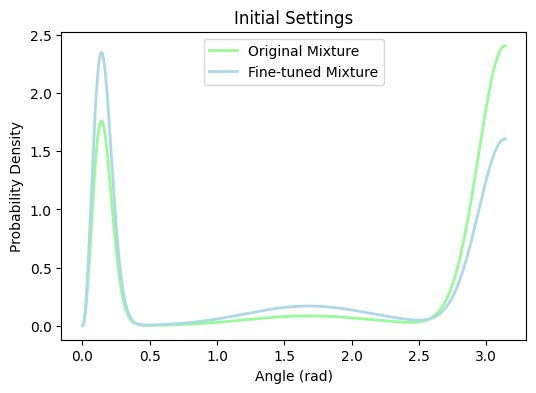

In [4]:
def visualize_initial_settings(
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    mus_finetune: torch.Tensor,
    sigmas_finetune: torch.Tensor,
    weights_finetune: torch.Tensor,
) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title("Initial Settings")
    omega, pdf = igso3_mixture_marginal_pdf(mus, sigmas, weights)
    omega_finetune, pdf_finetune = igso3_mixture_marginal_pdf(
        mus_finetune, sigmas_finetune, weights_finetune
    )
    ax.plot(
        omega.cpu().numpy(),
        pdf.cpu().numpy(),
        color="palegreen",
        lw=2,
        label="Original Mixture",
    )
    ax.plot(
        omega_finetune.cpu().numpy(),
        pdf_finetune.cpu().numpy(),
        color="lightblue",
        lw=2,
        label="Fine-tuned Mixture",
    )
    ax.set_xlabel("Angle (rad)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    plt.show()


visualize_initial_settings(
    mus,
    sigmas,
    weights,
    mus_finetune,
    sigmas_finetune,
    weights_finetune,
)

$$            \nabla_\mathbf{q} = \frac{\mathbf{q}}{|\mathbf{q}|} \frac{\tfrac{\partial}{\partial |\mathbf{q}|} f_{\mathrm{IGSO(3)}}(|\mathbf{q}|)}{f_{\mathrm{IGSO(3)}}(|\mathbf{q}|)}$$
$$            \frac{1}{\lambda} = \sqrt{\frac{\sum_\omega \left[\partial_\omega \log f_\mathrm{IGSO(3)}(\omega)\right]^2 f_\mathrm{IGSO(3)}(\omega)}{3 \sum_\omega f_\mathrm{IGSO(3)}(\omega)}}$$

In [5]:
def train(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    epochs: int = 20,
    batch_size: int = 4096,
    num_steps: int = 200,
    lr: float = 5e-3,
    weight_decay: float = 1e-4,
    eta_min: float = 1e-5,
    tol: float = 1e-7,
):
    # instantiate SDE and score model
    sde.to(device)
    score_model.to(device)

    # instantiate the mixture parameters
    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    optimizer = AdamW(score_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in range(1, epochs + 1):
        score_model.train()
        epoch_loss = 0.0
        pbar = tqdm(range(num_steps), desc=f"Epoch {epoch}", leave=False)
        for _ in pbar:
            loss = compute_train_loss(
                sde,
                score_model,
                mus,
                sigmas,
                weights,
                device=device,
                batch_size=batch_size,
                tol=tol,
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            l = loss.detach().item()
            epoch_loss += l
            pbar.set_postfix(loss=f"{l:.2f}")

        scheduler.step()
        avg_loss = epoch_loss / num_steps
        print(f"Epoch {epoch}: Average training loss = {avg_loss:.4f}")

        if epoch % 10 == 0:
            score_model.eval()
            with torch.no_grad():
                val_loss = compute_train_loss(
                    sde,
                    score_model,
                    mus,
                    sigmas,
                    weights,
                    device=device,
                    batch_size=batch_size,
                    tol=tol,
                )
            print(f"Validation loss: {val_loss:.4f}")


train(
    sde,
    score_model,
    mus,
    sigmas,
    weights,
    device=device,
)
# save the model
torch.save(score_model.state_dict(), "score_model.pt")
# load the model
score_model.load_state_dict(torch.load("score_model.pt"))

Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Average training loss = 0.9207


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Average training loss = 0.8524


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Average training loss = 0.8244


Epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Average training loss = 0.8198


Epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Average training loss = 0.8141


Epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Average training loss = 0.8131


Epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Average training loss = 0.8119


Epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Average training loss = 0.8111


Epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Average training loss = 0.8113


Epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Average training loss = 0.8078
Validation loss: 0.8090


Epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11: Average training loss = 0.8077


Epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12: Average training loss = 0.8074


Epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13: Average training loss = 0.8056


Epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14: Average training loss = 0.8057


Epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15: Average training loss = 0.8030


Epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16: Average training loss = 0.8018


Epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17: Average training loss = 0.8054


Epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18: Average training loss = 0.8039


Epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19: Average training loss = 0.8026


Epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20: Average training loss = 0.8029
Validation loss: 0.8357


<All keys matched successfully>

Reverse diffusion:   0%|          | 0/2000 [00:00<?, ?it/s]

Plotting:   0%|          | 0/8 [00:00<?, ?it/s]

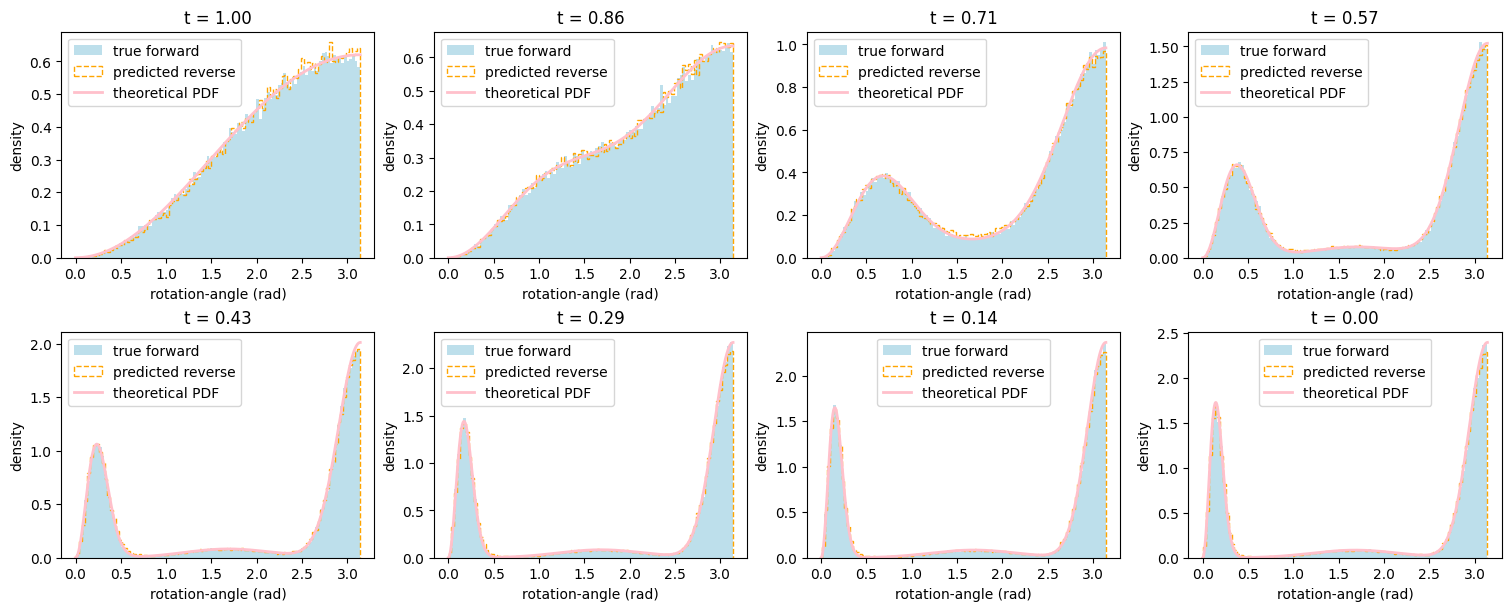

In [6]:
@torch.no_grad()
def visualize_diffusion(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    batch_size: int = 65536,
    num_steps: int = 2000,
    t_num: int = 8,
    l_max: int = 1000,
    num_points: int = 1000,
    tol: float = 1e-7,
):
    sde.to(device)
    score_model.to(device).eval()

    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    # reverse diffusion samples
    xs, t_vals = reverse_diffusion(
        sde, score_model, device=device, batch_size=batch_size, num_steps=num_steps
    )

    x_0 = sde.sample_multiple_igso3(
        mus, sigmas, weights, batch_size, device=device
    )  # (B,3,3)

    # pick checkpoints
    idxs = np.linspace(0, num_steps, t_num, dtype=int)
    fig, axes = plt.subplots(
        2, int(np.ceil(t_num / 2)), figsize=(15, 6), constrained_layout=True
    )
    axes: np.ndarray = axes.flatten()

    for i in trange(t_num, desc="Plotting", leave=False):
        # plot forward and reverse marginals
        ax: Axes = axes[i]
        idx = idxs[i]
        t_val = t_vals[idx].item()
        t = torch.full((batch_size,), t_val, device=device)

        # a) true forward histogram
        x_t = sde.sample_marginal(x_0, t)
        true_angles = angle_from_rotmat(x_t)[0]
        ax.hist(
            true_angles.cpu().numpy(),
            bins=100,
            density=True,
            alpha=0.8,
            label="true forward",
            color="lightblue",
        )

        # b) predicted reverse histogram
        x_rev = xs[idx]
        rev_angles = angle_from_rotmat(x_rev)[0]
        ax.hist(
            rev_angles.cpu().numpy(),
            bins=100,
            density=True,
            histtype="step",
            linestyle="--",
            linewidth=1,
            label="predicted reverse",
            color="orange",
        )

        # c) theoretical forward marginal (vectorized)
        sigma_t = torch.sqrt(sde._marginal_std(t_vals[idx]) ** 2 + sigmas**2)  # (K,)
        omega, pdf = igso3_mixture_marginal_pdf(
            mus,
            sigma_t,
            weights,
            l_max=l_max,
            num_points=num_points,
            tol=tol,
        )

        ax.plot(
            omega.cpu().numpy(),
            pdf.cpu().numpy(),
            color="pink",
            lw=2,
            label="theoretical PDF",
        )

        ax.set_title(f"t = {t_val:.2f}")
        ax.set_xlabel("rotation-angle (rad)")
        ax.set_ylabel("density")
        ax.legend()

    plt.show()


score_model.load_state_dict(torch.load("score_model.pt", map_location=device))
visualize_diffusion(sde, score_model, mus, sigmas, weights, device=device)

In [7]:
def finetune(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    finetune_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    lambda_: float = 0.2,
    epochs: int = 50,
    batch_size: int = 4096,
    num_steps: int = 200,
    l_max: int = 1000,
    lr: float = 5e-3,
    weight_decay: float = 1e-4,
    eta_min: float = 1e-5,
    tol: float = 1e-7,
):
    # instantiate SDE and score model
    sde.to(device)
    score_model.to(device).eval()
    finetune_model.to(device)

    # instantiate the mixture parameters
    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    optimizer = AdamW(finetune_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in trange(1, epochs + 1, desc="Epochs", leave=False):
        finetune_model.train()
        loss = compute_finetune_loss(
            sde,
            score_model,
            finetune_model,
            mus,
            sigmas,
            weights,
            lambda_=lambda_,
            device=device,
            batch_size=batch_size,
            num_steps=num_steps,
            l_max=l_max,
            tol=tol,
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = loss.detach().item()

        scheduler.step()
        print(f"Epoch {epoch}: Average training loss = {avg_loss:.4f}")

        if epoch % 10 == 0:
            finetune_model.eval()
            with torch.no_grad():
                val_loss = compute_finetune_loss(
                    sde,
                    score_model,
                    finetune_model,
                    mus,
                    sigmas,
                    weights,
                    lambda_=lambda_,
                    device=device,
                    batch_size=batch_size,
                    num_steps=num_steps,
                    l_max=l_max,
                    tol=tol,
                )
            print(f"Validation loss: {val_loss:.4f}")


score_model.load_state_dict(torch.load("score_model.pt", map_location=device))
finetune(
    sde,
    score_model,
    finetune_model,
    mus_finetune,
    sigmas_finetune,
    weights_finetune,
    device=device,
    lambda_=0.2,
)
# save the model
torch.save(finetune_model.state_dict(), "finetune_model.pt")
# load the model
finetune_model.load_state_dict(torch.load("finetune_model.pt"))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.5072277784347534
loss_kl -1.3351382222026587e-09
Epoch 1: Average training loss = 0.5072


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.49591299891471863
loss_kl -6.602931534871459e-10
Epoch 2: Average training loss = 0.4959


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.5073829889297485
loss_kl -5.538822733797133e-10
Epoch 3: Average training loss = 0.5074


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4793703854084015
loss_kl -5.529727786779404e-10
Epoch 4: Average training loss = 0.4794


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4802960455417633
loss_kl -1.2660166248679161e-09
Epoch 5: Average training loss = 0.4803


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.491093248128891
loss_kl -2.6193447411060333e-10
Epoch 6: Average training loss = 0.4911


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.45884162187576294
loss_kl -4.16184775531292e-09
Epoch 7: Average training loss = 0.4588


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4667813181877136
loss_kl -2.1609594114124775e-09
Epoch 8: Average training loss = 0.4668


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.46320995688438416
loss_kl -4.511093720793724e-09
Epoch 9: Average training loss = 0.4632


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.44940024614334106
loss_kl -8.585629984736443e-10
Epoch 10: Average training loss = 0.4494


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.43739357590675354
loss_kl -5.537003744393587e-09
Validation loss: 0.4374


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.44650229811668396
loss_kl -1.1059455573558807e-09
Epoch 11: Average training loss = 0.4465


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.45114272832870483
loss_kl -2.6047928258776665e-09
Epoch 12: Average training loss = 0.4511


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4593331813812256
loss_kl -4.0745362639427185e-10
Epoch 13: Average training loss = 0.4593


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4461212754249573
loss_kl -2.1827872842550278e-11
Epoch 14: Average training loss = 0.4461


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.445202499628067
loss_kl -2.066371962428093e-09
Epoch 15: Average training loss = 0.4452


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4644967317581177
loss_kl -3.0231603886932135e-09
Epoch 16: Average training loss = 0.4645


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.45229074358940125
loss_kl -1.3533281162381172e-09
Epoch 17: Average training loss = 0.4523


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4459567070007324
loss_kl -4.103640094399452e-09
Epoch 18: Average training loss = 0.4460


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4468710124492645
loss_kl -5.915353540331125e-09
Epoch 19: Average training loss = 0.4469


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4424913823604584
loss_kl -1.382431946694851e-09
Epoch 20: Average training loss = 0.4425


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4384477436542511
loss_kl -3.259629011154175e-09
Validation loss: 0.4384


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4424690008163452
loss_kl -3.92901711165905e-09
Epoch 21: Average training loss = 0.4425


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4415966868400574
loss_kl -4.220055416226387e-09
Epoch 22: Average training loss = 0.4416


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4414752423763275
loss_kl -3.2887328416109085e-09
Epoch 23: Average training loss = 0.4415


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.42882242798805237
loss_kl -5.9371814131736755e-09
Epoch 24: Average training loss = 0.4288


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4332647919654846
loss_kl -2.8740032576024532e-09
Epoch 25: Average training loss = 0.4333


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4285304844379425
loss_kl -5.762558430433273e-09
Epoch 26: Average training loss = 0.4285


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.43651071190834045
loss_kl -5.144102033227682e-09
Epoch 27: Average training loss = 0.4365


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4325585961341858
loss_kl -1.3387762010097504e-09
Epoch 28: Average training loss = 0.4326


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4405324459075928
loss_kl -3.1868694350123405e-09
Epoch 29: Average training loss = 0.4405


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4384056329727173
loss_kl -1.076841726899147e-09
Epoch 30: Average training loss = 0.4384


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4358096122741699
loss_kl -5.47879608348012e-09
Validation loss: 0.4358


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4344756007194519
loss_kl -6.28642737865448e-09
Epoch 31: Average training loss = 0.4345


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4318486154079437
loss_kl -4.3655745685100555e-10
Epoch 32: Average training loss = 0.4318


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.422345906496048
loss_kl -3.230525180697441e-09
Epoch 33: Average training loss = 0.4223


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4340665340423584
loss_kl -2.08092387765646e-09
Epoch 34: Average training loss = 0.4341


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4439525604248047
loss_kl -4.169123712927103e-09
Epoch 35: Average training loss = 0.4440


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4309884309768677
loss_kl -7.712515071034431e-10
Epoch 36: Average training loss = 0.4310


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.43911445140838623
loss_kl -2.837623469531536e-10
Epoch 37: Average training loss = 0.4391


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.43180495500564575
loss_kl -3.2014213502407074e-10
Epoch 38: Average training loss = 0.4318


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4234805405139923
loss_kl -5.11863618157804e-09
Epoch 39: Average training loss = 0.4235


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.43017709255218506
loss_kl -3.004970494657755e-09
Epoch 40: Average training loss = 0.4302


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.43734511733055115
loss_kl -5.3551048040390015e-09
Validation loss: 0.4373


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4343099296092987
loss_kl -1.7316779121756554e-09
Epoch 41: Average training loss = 0.4343


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.419420450925827
loss_kl -3.2014213502407074e-09
Epoch 42: Average training loss = 0.4194


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4252810478210449
loss_kl -3.768946044147015e-09
Epoch 43: Average training loss = 0.4253


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4186500906944275
loss_kl -3.346940502524376e-09
Epoch 44: Average training loss = 0.4187


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4422542452812195
loss_kl -1.6880221664905548e-09
Epoch 45: Average training loss = 0.4423


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4259135127067566
loss_kl -5.791662260890007e-09
Epoch 46: Average training loss = 0.4259


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4245123267173767
loss_kl -2.5793269742280245e-09
Epoch 47: Average training loss = 0.4245


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4379265308380127
loss_kl -4.43833414465189e-09
Epoch 48: Average training loss = 0.4379


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4324193000793457
loss_kl -4.423782229423523e-09
Epoch 49: Average training loss = 0.4324


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4308081567287445
loss_kl -5.537003744393587e-09
Epoch 50: Average training loss = 0.4308


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

loss_ev 0.4266104996204376
loss_kl -2.0372681319713593e-10
Validation loss: 0.4266


<All keys matched successfully>

Reverse diffusion:   0%|          | 0/2000 [00:00<?, ?it/s]

Plotting:   0%|          | 0/8 [00:00<?, ?it/s]

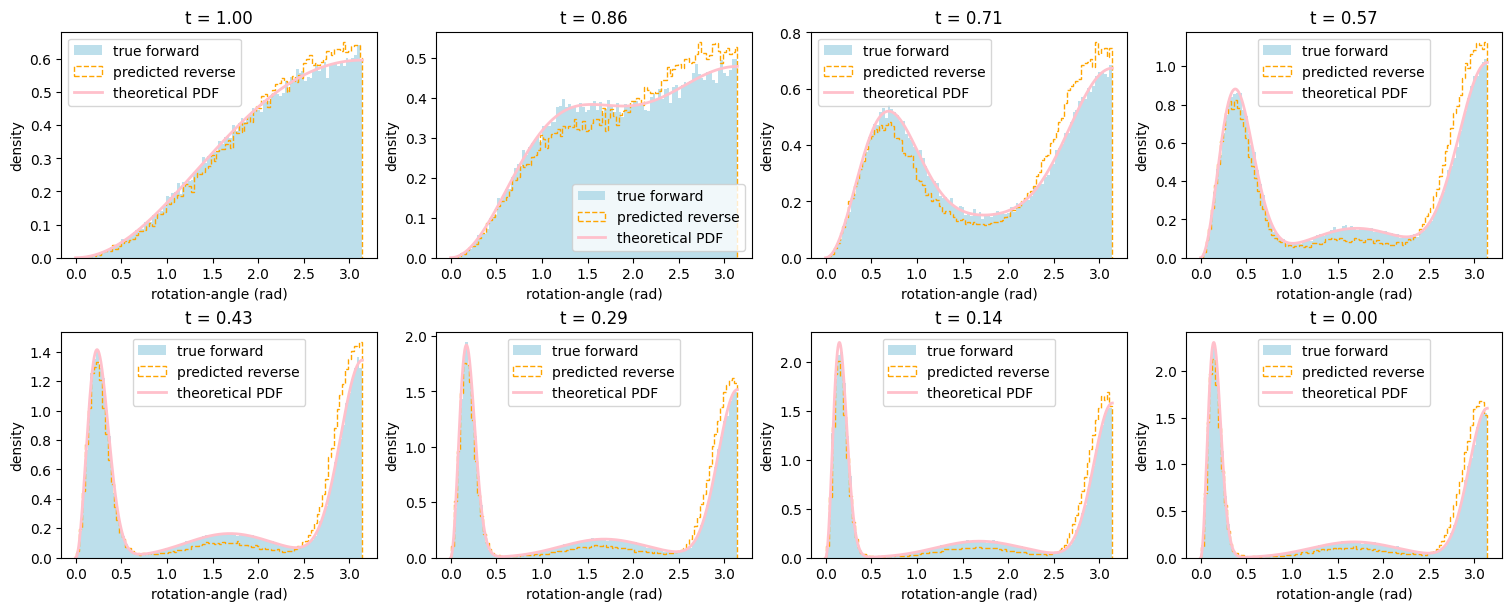

In [8]:
@torch.no_grad()
def visualize_finetune_diffusion(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    finetune_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    batch_size: int = 65536,
    num_steps: int = 2000,
    t_num: int = 8,
    l_max: int = 1000,
    num_points: int = 1000,
    tol: float = 1e-7,
):
    sde.to(device)
    score_model.to(device).eval()
    finetune_model.to(device).eval()

    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    # reverse diffusion samples
    xs, t_vals, *_ = reverse_finetune_diffusion(
        sde,
        score_model,
        finetune_model,
        device=device,
        batch_size=batch_size,
        num_steps=num_steps,
    )

    x_0 = sde.sample_multiple_igso3(
        mus, sigmas, weights, batch_size, device=device
    )  # (B,3,3)

    # pick checkpoints
    idxs = np.linspace(0, num_steps, t_num, dtype=int)
    fig, axes = plt.subplots(
        2, int(np.ceil(t_num / 2)), figsize=(15, 6), constrained_layout=True
    )
    axes: np.ndarray = axes.flatten()

    for i in trange(t_num, desc="Plotting", leave=False):
        # plot forward and reverse marginals
        ax: Axes = axes[i]
        idx = idxs[i]
        t_val = t_vals[idx].item()
        t = torch.full((batch_size,), t_val, device=device)

        # a) true forward histogram
        x_t = sde.sample_marginal(x_0, t)
        true_angles = angle_from_rotmat(x_t)[0]
        ax.hist(
            true_angles.cpu().numpy(),
            bins=100,
            density=True,
            alpha=0.8,
            label="true forward",
            color="lightblue",
        )

        # b) predicted reverse histogram
        x_rev = xs[idx]
        rev_angles = angle_from_rotmat(x_rev)[0]
        ax.hist(
            rev_angles.cpu().numpy(),
            bins=100,
            density=True,
            histtype="step",
            linestyle="--",
            linewidth=1,
            label="predicted reverse",
            color="orange",
        )

        # c) theoretical forward marginal (vectorized)
        sigma_t = torch.sqrt(sde._marginal_std(t_vals[idx]) ** 2 + sigmas**2)  # (K,)
        omega, pdf = igso3_mixture_marginal_pdf(
            mus,
            sigma_t,
            weights,
            l_max=l_max,
            num_points=num_points,
            tol=tol,
        )

        ax.plot(
            omega.cpu().numpy(),
            pdf.cpu().numpy(),
            color="pink",
            lw=2,
            label="theoretical PDF",
        )

        ax.set_title(f"t = {t_val:.2f}")
        ax.set_xlabel("rotation-angle (rad)")
        ax.set_ylabel("density")
        ax.legend()

    plt.show()


score_model.load_state_dict(torch.load("score_model.pt", map_location=device))
finetune_model.load_state_dict(torch.load("finetune_model.pt", map_location=device))
visualize_finetune_diffusion(
    sde,
    score_model,
    finetune_model,
    mus_finetune,
    sigmas_finetune,
    weights_finetune,
    device=device,
)